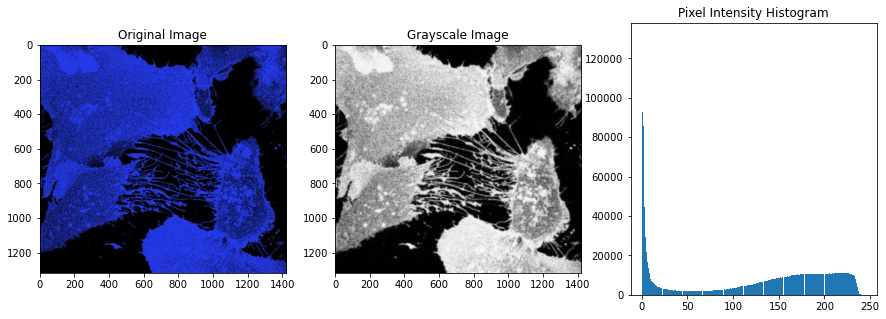

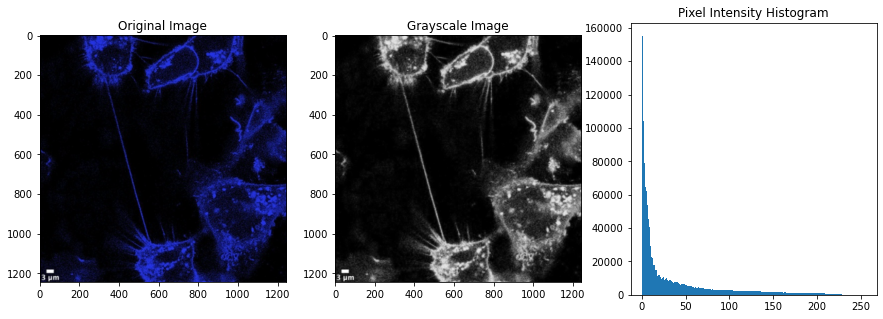

In [118]:
import cv2
import matplotlib.pyplot as plt
img_paths = ['img.png', 'img2.png']

def readin_image(path):
    img = cv2.imread(path)
    if img is None:
        print(f"Error: Could not read image from {path}.")
    return img

imgs = [readin_image(path) for path in img_paths]
#imgs_gray = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in imgs if img is not None]
imgs_gray = [im[:,:,2] for im in imgs if imgs is not None] #extract red channel

for i, img in enumerate(imgs):
    plt.figure(figsize=(15, 5))
    plt.subplot(1,3,1)  
    plt.imshow(img) 
    plt.title('Original Image') 
    plt.subplot(1,3,2)  
    plt.imshow(imgs_gray[i],cmap='gray')
    plt.title('Grayscale Image')
    plt.subplot(1,3,3)  
    plt.hist(imgs_gray[i].flatten(),bins=256)
    plt.title('Pixel Intensity Histogram')
    plt.show()

In [119]:
import matplotlib.pyplot as plt
import numpy as np
def tnt_plot(ori_img,gray,edges,lines, ridge_mask, overlaid_img=None, title='Img1'):
    plt.figure(figsize=(50, 10))
    plt.subplot(1,5,1)
    plt.imshow(cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB))
    plt.title(f"{title}")
    plt.axis('off') 
    
    plt.subplot(1,5,2)
    plt.imshow(gray, cmap='gray')
    plt.title(f'Preprocessed')
    plt.axis('off')

    plt.subplot(1,5,3)
    plt.imshow(edges, cmap='jet')
    plt.title(f"Edges: {np.count_nonzero(edges)} px")
    plt.axis('off')

    plt.subplot(1,5,4)
    plt.imshow(ridge_mask, cmap='jet')
    plt.title(f"Ridge Mask: {np.count_nonzero(ridge_mask)} px")
    plt.axis('off')

    plt.subplot(1,5,5)
    if overlaid_img is not None:
        plt.imshow(cv2.cvtColor(overlaid_img, cv2.COLOR_BGR2RGB))
    else:
        frame_with_lines = ori_img.copy()
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line
                cv2.line(frame_with_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(frame_with_lines, cv2.COLOR_BGR2RGB))
    if( lines is not None):
        plt.title(f"Hough Lines: {len(lines)}")
    else:
        plt.title("No Hough Lines")
    plt.axis('off')
    
    
    plt.show()



    return()

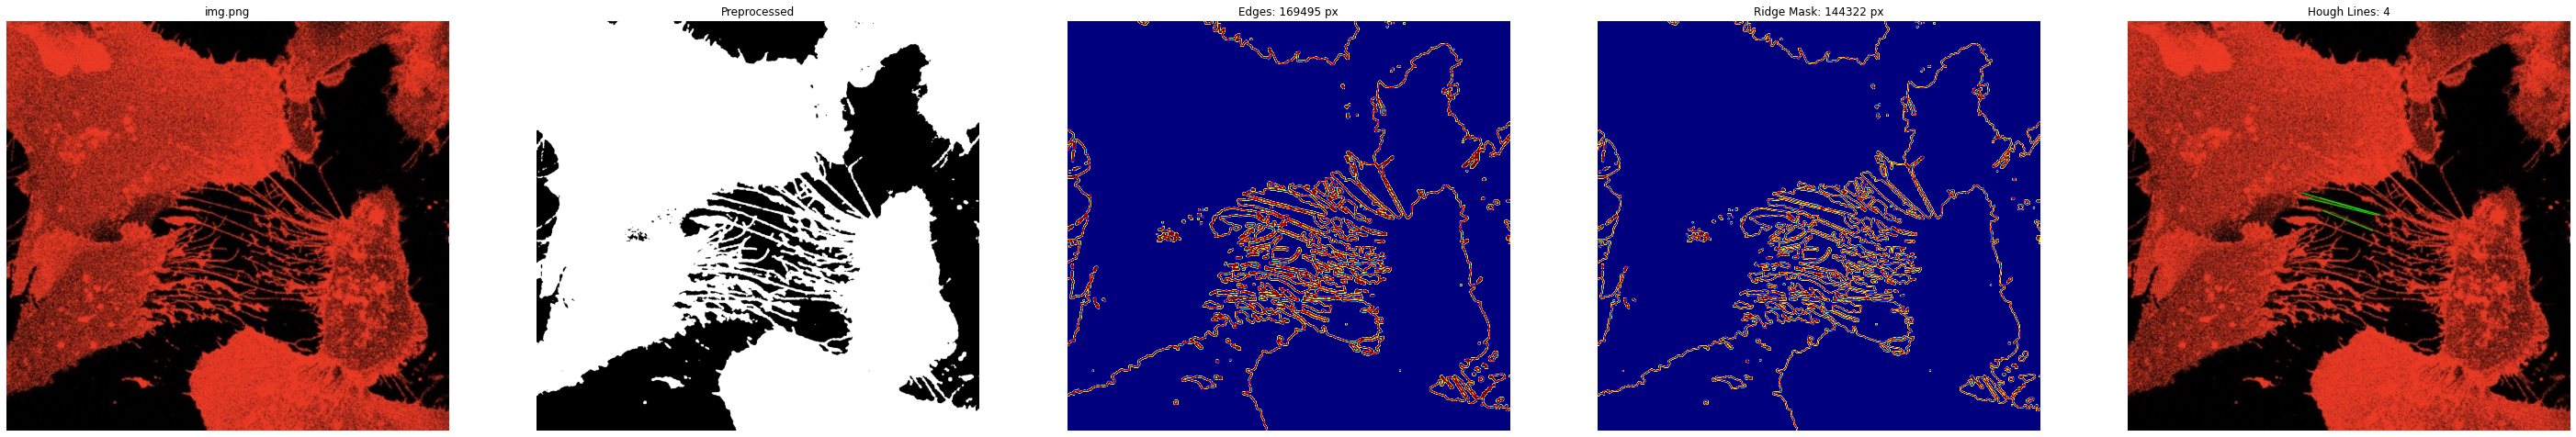

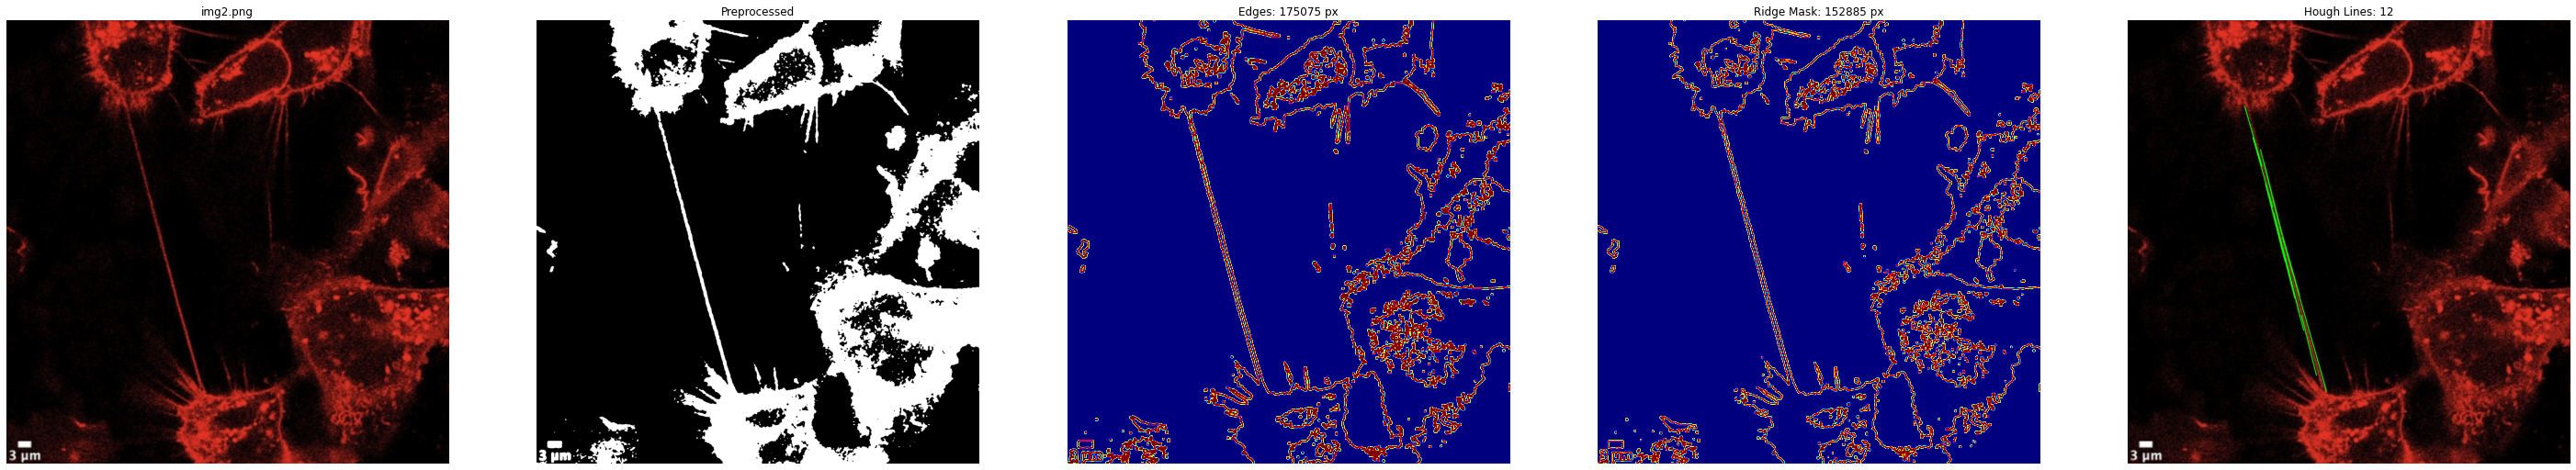

In [120]:
from matplotlib.cm import get_cmap

def merge_lines_fit(lines):
    if lines is None or len(lines) == 0:
        return []

    # Flatten if needed
    if isinstance(lines, np.ndarray) and lines.ndim == 3:
        lines = lines[:, 0, :]  # shape: (N, 4)

    # Collect all segment endpoints
    points = []
    for x1, y1, x2, y2 in lines:
        points.append([x1, y1])
        points.append([x2, y2])
    points = np.array(points, dtype=np.float32)

    # Fit a line through all endpoints
    vx, vy, x0, y0 = cv2.fitLine(points, cv2.DIST_L2, 0, 0.01, 0.01)
    direction = np.array([vx, vy]).flatten()
    origin = np.array([x0, y0]).flatten()

    # Normalize direction
    direction /= np.linalg.norm(direction)

    # Project all points onto the line to find span
    projections = (points - origin) @ direction
    pt1 = origin + direction * projections.min()
    pt2 = origin + direction * projections.max()

    return [[int(pt1[0]), int(pt1[1]), int(pt2[0]), int(pt2[1])]]





def detect_TNT(
    frame,
    canny_threshold=(150, 10),
    blur_ksize=(3, 3),
    dilation_ksize=(5, 5),
    dilation_iter=1,
    hough_rho=1,
    hough_theta=np.pi / 90,
    hough_threshold=200,
    min_line_length=100,
    max_line_gap=2,
    merge=False,
    merge_angle_thresh=np.pi / 180 * 5,
    merge_dist_thresh=30,
    clahe = False,
    threshold = None,
    use_ridge=True,
    ridge_ksize=(5, 5),
    ridge_thresh=30,
    filter_lines=True
):
    #height, width, _ = frame.shape
    #gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    gray = frame if frame.ndim == 2 else frame[:, :, 2]
    
    #Apply CLAHE if specified for enchancing contrast
    if clahe:
       clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(5,5))
       gray = clahe.apply(gray)

    gray = cv2.GaussianBlur(gray, blur_ksize, 1)

    # Thresholding
    if threshold is not None:
        _, gray = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)

    # ridge detection
    if use_ridge:
        ridge_like = cv2.morphologyEx(gray, cv2.MORPH_GRADIENT, cv2.getStructuringElement(cv2.MORPH_RECT, ridge_ksize))
        _, ridge_mask = cv2.threshold(ridge_like, ridge_thresh, 255, cv2.THRESH_BINARY)


    edges = cv2.Canny(gray, *canny_threshold)

    # Combine edges with ridge mask if enabled
    if use_ridge:
        edges = cv2.bitwise_and(edges, ridge_mask)

    # Dilation
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, dilation_ksize)
    edges = cv2.dilate(edges, kernel, iterations=dilation_iter)
    #edges = cv2.morphologyEx(edges, cv2.MORPH_OPEN, kernel)


    # Hough Line Detection
    raw_lines = cv2.HoughLinesP(
        edges,
        rho=hough_rho,
        theta=hough_theta,
        threshold=hough_threshold,
        minLineLength=min_line_length,
        maxLineGap=max_line_gap
    )

    if isinstance(raw_lines, np.ndarray) and raw_lines.ndim == 3:
        lines = raw_lines[:, 0, :]

    if merge and raw_lines is not None:
        lines = merge_lines_fit(lines)

    if filter_lines:
        filtered_lines = []
        for x1, y1, x2, y2 in lines:
            length = np.hypot(x2 - x1, y2 - y1)
            cx, cy = int((x1 + x2) / 2), int((y1 + y2) / 2)
            
            # Apply multiple criteria
            if length > 150 and gray[cy, cx] < 100:
                filtered_lines.append([x1, y1, x2, y2])

        lines = np.array(filtered_lines)#[:,0,:])

    # Draw output
    overlaid_frame = frame.copy()
    if lines is not None:
        lines = np.array(lines)
        lines = list(lines[:,0,:]) if (lines.ndim == 3) else lines
        for x1, y1, x2, y2 in lines:
            cv2.line(overlaid_frame, (x1, y1), (x2, y2), (0, 255, 0), 5)

    return frame, gray, overlaid_frame, edges, lines, ridge_mask


for i in range(len(imgs)):
    ori_img, gray_img, overlaid_frame, edges, lines, ridge_mask = detect_TNT(imgs[i],
                                                                 canny_threshold=(80, 2),
                                                                 threshold=50, 
                                                                 min_line_length=100,
                                                                 max_line_gap=2,
                                                                 ridge_ksize=(5,5),
                                                                 ridge_thresh=70,
                                                                 use_ridge=True)
    tnt_plot(imgs[i], gray_img, edges, lines, ridge_mask, title=img_paths[i])
# plt.title(f"Hough Lines Fitted: {len(lines)}")
# plt.show()


In [ ]:
param_grid = {
    'canny_threshold': [(80, 2), (90, 2), (100, 2)],
    'threshold': [40, 50, 60],
    'min_line_length': [80, 90, 100],
    'max_line_gap': [5, 7, 9],
    'ridge_thresh': [60, 70, 80],
}

from itertools import product

keys, values = zip(*param_grid.items())
for combo in product(*values):
    param_combo = dict(zip(keys, combo))
    print("Testing combo:", param_combo)

    for i, img in enumerate(imgs):
        ori_img, gray_img, overlaid_frame, edges, lines, ridge_mask = detect_TNT(img, **param_combo)
        tnt_plot(imgs[i], gray_img, edges, lines, ridge_mask, title=img_paths[i])